## Visualize Reexplore Training Results

### Set the following fields and run all. Example inputs are provided by default


In [42]:
# TODO: FIELDS TO SET IN THIS CELL, THEN RUN ALL.
# heuristics to compare
heuristics = [
    'e1r1r2',
    'e1s1r2', 
    'e1c1sr2', 
    'e1c1ppr2',
    'e1s1ppr2', 
]

# Directory with training output.

train_dir = '/checkpoint/apratik/jobs/reexplore/training/08-05-2022/08:01:32/' # no noise, instance + gtfix setting, ~33 trajectories
setting = 'instance'
noise = 'no_noise'
gtorpfix = 'gtfix'

visualize /checkpoint/apratik/jobs/reexplore/training/08-05-2022/08:01:32/
results for 33 trajectories ...


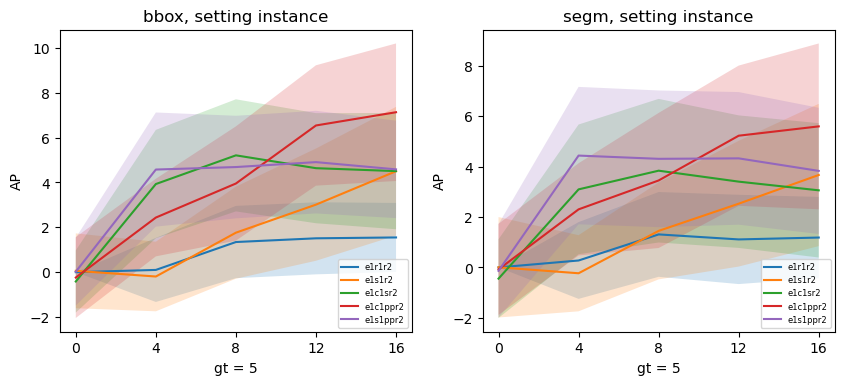

visualize /checkpoint/apratik/jobs/reexplore/training/08-05-2022/08:01:32/
results for 33 trajectories ...
with GT


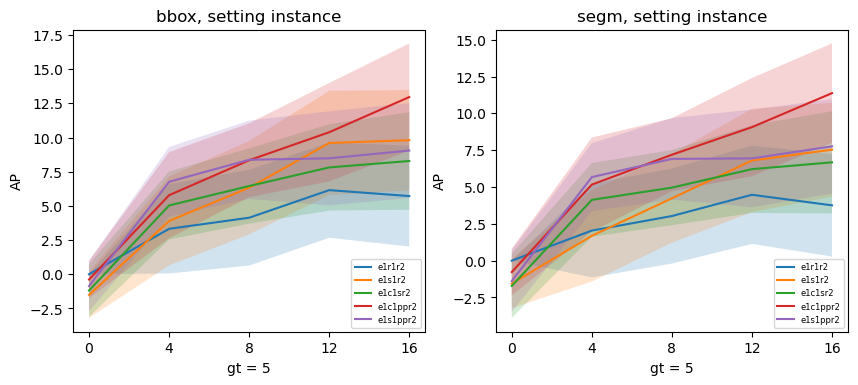

In [43]:
import glob
import json
import os
from typing import Union
from collections import namedtuple, defaultdict
import numpy as np
import matplotlib.pyplot as plt 
from math import sqrt


AP = namedtuple('AP', 'bbox, segm')
# heuristics = ['e1r1r2', 'e1s1r2', 'e1c1lr2']

def load_json(json_path):
    lines = []
    # print(f'looking at {json_path}')
    with open(json_path, 'r') as f:
        ls = f.readlines()
        for line in ls:
            try:
                lines.append(json.loads(line))
            except json.JSONDecodeError:
                print(f'JSONDecodeError {len(line), line[:2]}')
                continue
    return lines

def get_traj_heuristic_gt_p(j, setting, with_gt):
    j = j.split('/')
    traj = j[j.index(setting)-1]
    gt = j[j.index(setting)+1]
    heu = j[j.index(setting)+2]
    pred_label = j[j.index(setting)+3]
    p = pred_label[pred_label.find('pred_label_p') + len('pred_label_p'):-(len('_with_gt') if with_gt else 1)]
    return traj, heu, gt, p

def get_best_ap(train_dir, setting):
    """
    has metrics for each hyperparam set. 
    find lowest validation loss, and take corresponding training AP.
    """
    def get_ap(l):
        ap_bbox, ap_segm = None, None
        prefix = '_val' if setting == 'instance' else '_test'
        for k, v in l.items():
            if k.endswith(f'{prefix}/bbox/AP'):
                # print(k)
                ap_bbox = l[k]
            if k.endswith(f'{prefix}/segm/AP'):
                # print(k)
                ap_segm = l[k]
        # print(f'get_ap {ap_bbox, ap_segm}')
        return AP(ap_bbox, ap_segm)            

    def process_json(j):
        x = load_json(m)
        best_val, best_ap = float('inf'), AP(0, 0)
        best_iter = 0
        for l in x:
            if 'validation_loss' in l:
                val_loss = l['validation_loss']
                if val_loss < best_val:
                    best_val = val_loss
                    best_iter = l['iteration']
                    ap = get_ap(l)
                    if ap.bbox is not None and ap.segm is not None:
                        best_ap = ap
        return best_val, best_ap, best_iter
    
    metric_jsons = glob.glob(train_dir + '/**/metrics.json', recursive=True)        

    # Group json by hyperparms
    def group_by(jsons):
        mj = defaultdict(list)
        for j in jsons:
            js = j.split('/')
            
            def extract_heu_idx(js):
                for h in heuristics:
                    if h in js:
                        return js.index(h)
                return -1
            
            tix = extract_heu_idx(js)
            key = '_'.join(js[tix: tix+6])
            mj[key].append(j)
        return mj

    metric_jsons = group_by(metric_jsons)
    # print(f'printing {len(metric_jsons)} metric_json')
    # for m, v in metric_jsons.items():
    #     print(f'\nkey {m}')
    #     for vv in v:
    #           print(f'value {vv}')

    best_val, best_test_ap = float('inf'), AP(0,0)
    best_mjson = None

    for k, v in metric_jsons.items():
        # process all jsons for this hyperparam set
        val_losses, test_aps = [], []
        for m in v:
            val_loss, test_ap, best_iter = process_json(m)
            # print(f'metric_json {m}, val_loss {val_loss}, test_ap {test_ap}, best_iter {best_iter}')
            val_losses.append(val_loss)
            test_aps.append(test_ap)
        val_avg = np.average(val_losses)
        test_avg = AP(np.average([p.bbox for p in test_aps]), np.average([p.segm for p in test_aps]))
        # print(f'\ntrain_dir {train_dir}\nhyperparams {k}, val_losses {val_losses}, test_aps {test_aps}')
        # print(f'val_avg {val_avg}, test_avg {test_avg}, val_min {np.min(val_losses)}')
        if val_avg < best_val:
            best_val = val_avg
            # best_test_ap = test_avg
            best_test_ap = test_aps
            best_mjson = k

    # print(f'train_dir {train_dir}\nbest val {best_val}, best iter {best_iter} best_ap {best_test_ap}\nbest mjson {best_mjson}\n')
    # print(best_val, best_test_ap)
    return best_test_ap

def process(j: str, setting, with_gt) -> Union[str, int, int, float]:
    # print(j)
    traj, heu, gt, p = get_traj_heuristic_gt_p(j, setting, with_gt)
    # print(heu, gt, p)

    #get best AP- this is not per json, but per pre_label_p0
    ap = get_best_ap(j, setting)
    return traj, heu, gt, p, ap

def pprint(d):
    for k, v in d.items():
        for h in heuristics:
            if h in k:
                print(k, v)

def get_values(all_scores, h, gt, p):
        key = '_'.join([h, str(gt), str(p)])
        if key in all_scores:
            aps = all_scores[key]
            # print(f'get_values {key}, {aps}')
            # aps = [x for y in aps for x in y]
            try:
                avg = AP(np.average([p.bbox for p in aps]), np.average([p.segm for p in aps]))
                var = AP(np.var([p.bbox for p in aps]), np.var([p.segm for p in aps]))
            except Exception as ex:
                print(f'exception {ex} key {key} aps {aps}')
                return None, None
            # print(aps, avg, var)
            return avg, var
        
        return None, None

def plot(scores, setting, gts, ps, figname):
    def draw(heu, xs, ys_bbox, ys_bb_err, ys_segm, ys_se_err, ax1, ax2, xlabel, figname):
        # print(f'len xs {len(xs)}, len ys {len(ys_bbox), len(ys_segm)}')
        # print(f'ys_bb_err {ys_bb_err}, ys_se_err {ys_se_err}')
        ax1.set_title(f'bbox, setting {setting}')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel('AP')
        ax1.plot(xs, ys_bbox, label=heu)
        ax1.fill_between(
            xs, 
            np.asarray(ys_bbox) - np.asarray(ys_bb_err)/2, 
            np.asarray(ys_bbox) + np.asarray(ys_bb_err)/2,
            alpha=0.2
        )
        ax1.set_xticks(xs)
        # ax1.errorbar(xs, ys_bbox, yerr=None, label=heu)
        ax1.legend(loc="lower right", prop={'size':6})
        # ax1.set_ylim(ymin=0)

        ax2.set_title(f'segm, setting {setting}')
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel('AP')
        ax2.plot(xs, ys_segm, label=heu)
        ax2.fill_between(
            xs, 
            np.asarray(ys_segm) - np.asarray(ys_se_err)/2, 
            np.asarray(ys_segm) + np.asarray(ys_se_err)/2,
            alpha=0.2
        )
        ax2.set_xticks(xs)
        # ax2.errorbar(xs, ys_segm, yerr=None, label=heu)
        # ax2.set_ylim(ymin=0)

        ax2.legend(loc="lower right", prop={'size':6})
    
    # for each heuristic, plot gt, p
    
    if len(gts) == 1:
        # ps are the x-values
        # ap are the y-values 
        # xs = ps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=100)
        for h in heuristics:
            xs, ys_bb, ys_bb_err, ys_se, ys_se_err = [], [], [], [], []
            for p in ps:
                y_ap, y_err = get_values(scores, h, gts[0], p)
                if y_ap is not None:
                    xs.append(p)
                    ys_bb.append(y_ap.bbox)
                    ys_bb_err.append(sqrt(y_err.bbox))
                    ys_se.append(y_ap.segm)
                    ys_se_err.append(sqrt(y_err.segm))

            if len(ys_bb) > 0 and len(ys_se) > 0:
                draw(h, xs, ys_bb, ys_bb_err, ys_se, ys_se_err, ax1, ax2, f'gt = {gts[0]}', figname)
        plt.show()

    if len(ps) == 1:
        # gts are the x-values
        # ap are the y-values 
        xs = gts
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=100)
        for h in heuristics:
            ys_bb, ys_bb_err, ys_se, ys_se_err = [], [], [], []
            for gt in gts:
                y_ap, y_err = get_values(scores, h, gt, ps[0])
                if y_ap is not None:
                    ys_bb.append(y_ap.bbox)
                    ys_bb_err.append(sqrt(y_err.bbox))
                    ys_se.append(y_ap.segm)
                    ys_se_err.append(sqrt(y_err.segm))

            if len(ys_bb) > 0 and len(ys_se) > 0:
                draw(h, xs, ys_bb, ys_bb_err, ys_se, ys_se_err, ax1, ax2, 'p fixed', figname)

def is_eligible(t, with_gt):
    if with_gt:
        return '_with_gt' in t
    return '_with_gt' not in t

def normalize(scores, trajs):
    def sub_ap(a, b):
        if not isinstance(a, AP) or not isinstance(b, AP):
            return AP(0,0)
        return AP(a.bbox-b.bbox, a.segm-b.segm)
    
    # normalize everything with baseline p0
    # get gt, p values for each heuristic
    # normalize with baseline_gt_0
    normalized_scores = defaultdict(list)

    for tr in trajs:
        gt = 5
        baseline = scores[f'{tr}_e1r1r2_{gt}_0']
        # print(baseline)
        for k, v in scores.items():
            if k.startswith(f'{tr}_'):
                try:
                    if len(v)>0 and len(baseline)>0:
                        normalized_scores[k] = [sub_ap(v[0][i], baseline[0][i]) for i in range(len(v[0]))]
                except Exception as ex:
                    pass
                    # print(f'exception {ex}, k {k}, v {v}, baseline {baseline}')
                # print(f'after {normalized_scores[k][:2]}')
            # print(scores, normalized_scores)
    return normalized_scores

def cumulate(scores):
    cumulative = defaultdict(list)
    for k, v in scores.items():
        new_key = '_'.join(k.split('_')[1:])
        # print(f'new_key {new_key}, values {v}')
        cumulative[new_key].append(v)
    
    # flatten
    for k, v in cumulative.items():
        cumulative[k] = [x for y in v for x in y]
        # print(f'key {k}, values {len(cumulative[k])}')
    return cumulative

def visualize(job_dir, setting, figname, with_gt=False, individual=False):
    """
    visualize setting - gt fixed, p fixed
    draws as many lines as there are heuristic combinations 
    """
    print(f'visualize {job_dir}')
    # train_dirs = glob.glob(job_dir + '/**/training', recursive=True)
    
    # tdirs = [x for x in train_dirs if setting in x]
    # print(f'{len(tdirs), tdirs[:10]} training directories')
    
    all_scores = defaultdict(list) 
    trajs = set()
    
    if individual:
        train_dirs = glob.glob(job_dir + '/**/training', recursive=True)
        print(f'train_dirs {train_dirs}')
        tdirs = [x for x in train_dirs if setting in x]
        for t in tdirs:
            if is_eligible(t, with_gt):
                traj, heu, gt, p, ap = process(t, setting, with_gt)
                # print(heu, gt, p, ap, t)
                trajs.add(traj)
                all_scores['_'.join([traj, heu, gt, p])].append(ap) 
        
    else:
        for x in os.listdir(job_dir):
            if x.isdigit(): 
                trajs.add(x)
                train_dirs = glob.glob(os.path.join(job_dir, x) + '/**/training', recursive=True)
                tdirs = [x for x in train_dirs if setting in x]
                for t in tdirs:
                    if is_eligible(t, with_gt):
                        traj, heu, gt, p, ap = process(t, setting, with_gt)
                        # print(heu, gt, p, ap, t)
                        trajs.add(traj)
                        all_scores['_'.join([traj, heu, gt, p])].append(ap) 
            

    print(f'results for {len(trajs)} trajectories ...')
    
    # pprint(all_scores)
    scores = cumulate(normalize(all_scores, trajs))
    # print(f'normalized accumulated scores {scores}')
    
    if with_gt:
        print(f'with GT')
    plot(scores, setting, gts=[5], ps=range(0,20,2), figname=figname)



# train_dir = '/checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05' # 4/22 run with 17 trajectories
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/26-04-2022/10:36:46' # 4/26 run with 12 trajectories

# large >200 run, 4 training samples each, interrupted after ~12 hours 
# train_dir ='/checkpoint/apratik/jobs/reexplore/training/01-05-2022/02:31:48' 

# large >200 run, 1 training sample each, interrupted due to random seed bug
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/01-05-2022/21:19:26' 

# train_dir = '/checkpoint/apratik/jobs/reexplore/training/05-05-2022/15:20:53' # final run

# train_dir = '/checkpoint/apratik/jobs/reexplore/training/06-05-2022/12:42:43' # test run for 82, s1 and r1, no early stopping, 600 iters
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/06-05-2022/12:41:26/' # local test run for 82, s1, no early stopping, 600 iters, too slow

# train_dir = '/checkpoint/apratik/jobs/reexplore/training/06-05-2022/14:19:46' # 3 runs each

# first run with s1pp and c1pp
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/07-05-2022/12:47:24'

# run with fixes here https://docs.google.com/presentation/d/1aNDu5mabOPebcgoowaBtnfQAbdRTInsl337TZeDwKqY/edit#slide=id.g11bb13202eb_0_59
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/08-05-2022/00:56:20' 

# run with fixes, just more trajectoris (33), no noise
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/08-05-2022/08:01:32/'
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/08-05-2022/20:06:11/'

# run with fixes, small batch, noise
# train_dir = '/checkpoint/soumith/jobs/reexplore/training/11-05-2022/09:51:35/'
# train_dir = '/checkpoint/soumith/jobs/reexplore/training/13-05-2022/08:33:06'


# setting = 'instance'
# noise = 'no_noise'
# gtorpfix = 'gtfix'

visualize(train_dir, setting, f'[{setting}]_[{noise}]_[{gtorpfix}]')
visualize(train_dir, setting, f'[{setting}]_[{noise}]_[{gtorpfix}]', with_gt=True)


# Uncomment below to visualize individual trajectories by setting individual=True
# cnt = 0
# trajs = set()
# for x in os.listdir(train_dir):
#     if x.isdigit():
#         trajs.add(x)
#         visualize(os.path.join(train_dir, x), 'class', individual=True)
        # visualize(os.path.join(train_dir, x), 'instance', with_gt=True, individual=True)
        # break

        # visualize(os.path.join(train_dir, x), 'instance', with_gt=True)

# visualize(train_dir, 'instance', with_gt=True)